# Introdução
Nesse trabalho irei prever o sucesso de startups usando machine learning.
A ideia é pegar os dados, limpar eles, explorar com alguns gráficos e depois treinar um modelo.
Com o objetivo de atinjir uma acurácia boa e avaliar as métricas de precisão, recall e F1.


Nessa parte é importado todas as bibliotecas que serão usadas nesse projeto, tanto para análise de dados quanto para machine learning.  
Também é carregado os arquivos `train.csv`, `test.csv` e `sample_submission.csv`.  
É mostrado o tamanho dos datasets, um preview das primeiras linhas e a distribuição da variável alvo (`labels`).  
Isso é importante para começar a entender os dados.


In [15]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

sns.set(style='whitegrid')

# Carregar dados
train = pd.read_csv('./database/train.csv')
test = pd.read_csv('./database/test.csv')
sample_submission = pd.read_csv('./database/sample_submission.csv')

print(train.shape, test.shape)
display(train.head())
print(train['labels'].value_counts())


(646, 33) (277, 32)


,id,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,...,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,labels
0,719,10.42,13.09,8.98,12.72,4,3,4087500,3,1,...,0,0,1,1,0,0,0,0,1.0,0
1,429,3.79,3.79,NaN,NaN,21,1,45000000,0,0,...,0,0,0,0,0,1,0,0,1.0,1
2,178,0.71,2.28,1.95,2.28,5,2,5200000,2,1,...,0,1,1,0,1,0,0,0,1.0,0
3,197,3.00,5.00,9.62,10.39,16,2,14500000,2,0,...,0,0,0,1,0,1,0,0,2.0,1
4,444,0.66,5.88,6.21,8.61,29,5,70000000,4,1,...,0,0,0,0,1,1,1,1,2.8,1


labels
1    418
0    228
Name: count, dtype: int64


# Exploração rápida

  
1. Verifico como está a distribuição da variável `labels` para ver se o dataset é balanceado ou não.  
2. Confiro se existem valores nulos em alguma coluna, porque isso pode influenciar no modelo e precisa ser tratado.

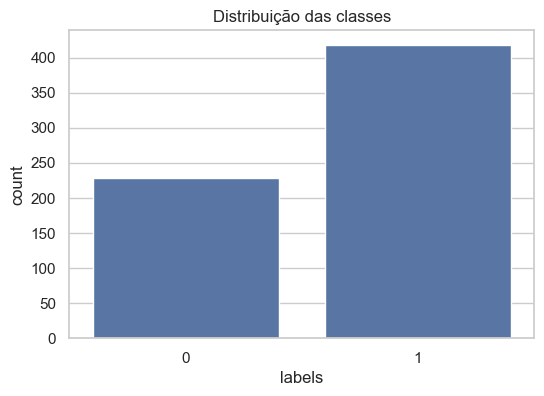

Valores nulos por coluna:
 age_first_funding_year       35
age_last_funding_year         9
age_first_milestone_year    138
age_last_milestone_year     111
funding_duration             35
milestone_duration          138
dtype: int64


In [14]:
# gráfico para ver a distribuição da variável alvo
plt.figure(figsize=(6,4))
sns.countplot(x='labels', data=train)
plt.title("Distribuição das classes")
plt.show()

# verificando valores nulos em cada coluna
missing = train.isnull().sum()
missing = missing[missing > 0]  # filtrando só colunas com nulos
print("Valores nulos por coluna:\n", missing)


# Feature engineering

Criei novas variáveis para ajudar o modelo a entender melhor os dados.  
As principais coisas que fiz:  
1. Criação de flags para identificar valores nulos.  
2. Cálculo de diferenças de tempo entre funding e milestones.  
3. Criação de variáveis de proporção (ex: milestones por rodada).  
4. Criação de interações simples entre variáveis (ex: rodadas x relacionamentos).  
5. Transformação logarítmica para reduzir impacto de valores muito grandes em funding.  
6. Agrupamento das categorias mais raras em `category_code` para não gerar ruído.  

In [16]:
# criar colunas indicando se tinha valor nulo (1) ou não (0)
for col in ['age_first_funding_year', 'age_last_funding_year', 
            'age_first_milestone_year', 'age_last_milestone_year']:
    if col in train.columns:
        train[col + '_missing'] = train[col].isnull().astype(int)
        test[col + '_missing'] = test[col].isnull().astype(int)

# diferença entre o primeiro e o último ano de funding
if {'age_last_funding_year','age_first_funding_year'}.issubset(train.columns):
    train['funding_duration'] = train['age_last_funding_year'] - train['age_first_funding_year']
    test['funding_duration'] = test['age_last_funding_year'] - test['age_first_funding_year']

# diferença entre o primeiro e o último milestone
if {'age_last_milestone_year','age_first_milestone_year'}.issubset(train.columns):
    train['milestone_duration'] = train['age_last_milestone_year'] - train['age_first_milestone_year']
    test['milestone_duration'] = test['age_last_milestone_year'] - test['age_first_milestone_year']

# milestones por rodada de investimento
if {'milestones','funding_rounds'}.issubset(train.columns):
    train['milestones_per_round'] = train['milestones'] / (train['funding_rounds'] + 1)
    test['milestones_per_round'] = test['milestones'] / (test['funding_rounds'] + 1)

# média de funding por rodada
if {'funding_total_usd','funding_rounds'}.issubset(train.columns):
    train['avg_funding_per_round'] = train['funding_total_usd'] / (train['funding_rounds'] + 1)
    test['avg_funding_per_round'] = test['funding_total_usd'] / (test['funding_rounds'] + 1)

# funding por milestone
if {'funding_total_usd','milestones'}.issubset(train.columns):
    train['funding_per_milestone'] = train['funding_total_usd'] / (train['milestones'] + 1)
    test['funding_per_milestone'] = test['funding_total_usd'] / (test['milestones'] + 1)

# interação entre rodadas e relacionamentos
if {'funding_rounds','relationships'}.issubset(train.columns):
    train['rounds_x_relationships'] = train['funding_rounds'] * train['relationships']
    test['rounds_x_relationships'] = test['funding_rounds'] * test['relationships']

# interação entre milestones e relacionamentos
if {'milestones','relationships'}.issubset(train.columns):
    train['milestones_x_relationships'] = train['milestones'] * train['relationships']
    test['milestones_x_relationships'] = test['milestones'] * test['relationships']

# transformações log para reduzir impacto de valores muito grandes
if 'funding_total_usd' in train.columns:
    train['log_funding'] = np.log1p(train['funding_total_usd'])
    test['log_funding'] = np.log1p(test['funding_total_usd'])

    train['log_funding_per_round'] = train['log_funding'] / (train['funding_rounds'] + 1)
    test['log_funding_per_round'] = test['log_funding'] / (test['funding_rounds'] + 1)

# agrupamento de categorias mais comuns e criação de "other" para o resto
if 'category_code' in train.columns:
    top_categories = train['category_code'].value_counts().nlargest(10).index
    train['category_code'] = train['category_code'].where(train['category_code'].isin(top_categories), 'other')
    test['category_code'] = test['category_code'].where(test['category_code'].isin(top_categories), 'other')


# Formulação de hipóteses

Hipóteses sobre fatores que influenciam o sucesso da startup:

Startups com mais rodadas de financiamento (funding_rounds) têm maior chance de sucesso.

Startups com mais relacionamentos/contatos (relationships) tendem a ter melhor desempenho.

Startups fundadas mais recentemente (menor age_first_funding_year) podem ter maior risco de falha devido à experiência limitada.

# Seleção de features

Aqui eu separei as colunas em três tipos principais:  
- **numéricas**: valores contínuos como funding, rodadas, relacionamentos.  
- **categóricas**: variáveis de texto como `category_code`.  
- **binárias**: colunas que são 0/1, como indicadores de "tem/não tem" ou flags de missing.  

Essa separação é importante porque cada tipo de dado precisa de um tratamento diferente no pré-processamento.  
Também incluí uma checagem para garantir que só entram colunas que realmente existem no dataset, evitando erros.

In [17]:
# lista inicial de colunas numéricas que vou usar
num_cols = [
    'funding_total_usd', 'relationships', 'age_first_funding_year', 'age_last_funding_year',
    'funding_rounds', 'milestones', 'age_first_milestone_year', 'age_last_milestone_year',
    'milestones_per_round', 'funding_duration', 'milestone_duration', 'avg_funding_per_round',
    'funding_per_milestone', 'rounds_x_relationships', 'milestones_x_relationships',
    'log_funding', 'log_funding_per_round'
]

# coluna categórica principal
cat_cols = ['category_code']

# colunas binárias: flags "is_", "has_" ou "_missing"
bin_cols = [c for c in train.columns if c.startswith('is_') or c.startswith('has_')] + \
           [c for c in train.columns if c.endswith('_missing')]

# checagem para garantir que todas as colunas existem no dataset
num_cols = [c for c in num_cols if c in train.columns]
cat_cols = [c for c in cat_cols if c in train.columns]
bin_cols = [c for c in bin_cols if c in train.columns]

# visualização rápida para confirmar
print("Num cols:", num_cols)
print("Cat cols:", cat_cols)
print("Bin cols (exemplo):", bin_cols[:10])


Num cols: ['funding_total_usd', 'relationships', 'age_first_funding_year', 'age_last_funding_year', 'funding_rounds', 'milestones', 'age_first_milestone_year', 'age_last_milestone_year', 'milestones_per_round', 'funding_duration', 'milestone_duration', 'avg_funding_per_round', 'funding_per_milestone', 'rounds_x_relationships', 'milestones_x_relationships', 'log_funding', 'log_funding_per_round']
Cat cols: ['category_code']
Bin cols (exemplo): ['is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate', 'is_software', 'is_web', 'is_mobile', 'is_enterprise', 'is_advertising']


# Pré-processamento / Pipeline

Aqui montei o pipeline de pré-processamento:  
1. Para variáveis **numéricas**: substituí valores nulos pela mediana e normalizei com `StandardScaler`.  
2. Para variáveis **categóricas**: preenchi nulos com "missing" e apliquei `OneHotEncoder` para transformar em dummies.  
3. Para variáveis **binárias**: deixei como estão (`passthrough`), já que já estão no formato 0/1.  

Isso garante que todos os dados estejam no formato certo para treinar o modelo sem erros.

In [18]:
# pipeline para tratar colunas numéricas
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),   # preenche nulos com a mediana
    ('scaler', StandardScaler())                     # normaliza os valores
])

# pipeline para tratar colunas categóricas
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # preenche nulos com "missing"
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # transforma em dummies
])

# juntando tudo em um ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', num_transformer, num_cols),   # aplica às numéricas
    ('cat', cat_transformer, cat_cols),   # aplica às categóricas
    ('bin', 'passthrough', bin_cols)      # passa as binárias sem mexer
], remainder='drop')  # ignora o resto das colunas


# Split treino/validação

Aqui separamos os dados em **features (X)** e **target (y)**:  
X contém todas as colunas menos a coluna `labels`.  
y contém a coluna `labels`, que indica o sucesso da startup.  

Depois, usamos `train_test_split` para dividir os dados em treino (80%) e validação (20%), mantendo a mesma proporção das classes com `stratify=y`.  
Isso garante que o modelo seja treinado e avaliado de forma consistente.

In [19]:
# separando features e target
X = train.drop('labels', axis=1)  # todas as colunas menos a target
y = train['labels']               # apenas a coluna target

# separando treino e validação
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,      # 20% para validação
    random_state=42,    # garante reprodutibilidade
    stratify=y          # mantém proporção das classes
)


# GridSearch usado naquele run

Nesta célula, construi um **pipeline** que combina o pré-processamento das features com o modelo **Random Forest**.  
1. Usando `class_weight='balanced'` para lidar com possíveis desequilíbrios entre classes.  
2. Realizando um **GridSearchCV** para testar diferentes combinações de hiperparâmetros e encontrar os que maximizam a acurácia.  
3. Avaliando o modelo usando **5-fold cross-validation** para garantir resultados mais confiáveis.

In [20]:
# Criando o pipeline com pré-processamento e modelo
rf_model = Pipeline([
    ('preprocessor', preprocessor),  # aplica o tratamento das colunas numéricas, categóricas e binárias
    ('classifier', RandomForestClassifier(
        class_weight='balanced',    # ajuda com classes desbalanceadas
        random_state=42             # garante reprodutibilidade
    ))
])

# Definindo os hiperparâmetros que vamos testar
param_grid = {
    'classifier__n_estimators': [800, 1000],        # número de árvores
    'classifier__max_depth': [15, None],            # profundidade máxima
    'classifier__min_samples_split': [2, 5],        # mínimo de amostras para dividir nó
    'classifier__min_samples_leaf': [1],            # mínimo de amostras em folha
    'classifier__max_features': ['sqrt', 'log2']    # número de features consideradas em cada split
}

# Grid Search com 5-fold cross-validation
grid_search = GridSearchCV(
    rf_model,
    param_grid,
    cv=5,
    scoring='accuracy',  # métrica principal
    n_jobs=-1,           # usa todos os núcleos do processador
    verbose=1            # exibe progresso
)

# Treinando e ajustando o modelo
grid_search.fit(X_train, y_train)

# Mostrando os melhores parâmetros encontrados
print("Melhores parâmetros:", grid_search.best_params_)

# Selecionando o melhor modelo
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Melhores parâmetros: {'classifier__max_depth': 15, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 800}


# Validação cruzada + avaliação

Aqui avalia o modelo ajustado (`best_model`) usando **cross-validation** e dados de validação separados.  
1. Calculamos **accuracy média** com `StratifiedKFold` para ter uma visão robusta do desempenho.  
2. Avaliamos métricas principais: **Accuracy, Precision, Recall e F1-score**.  
3. Geramos o **classification report** para analisar desempenho por classe.  
4. Por fim, exibimos a **matriz de confusão** para visualizar acertos e erros de forma intuitiva.

Acurácia média CV: 0.7848062015503876
Accuracy: 0.7923076923076923
Precision: 0.8064516129032258
Recall: 0.8928571428571429
F1-score: 0.847457627118644

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.61      0.67        46
           1       0.81      0.89      0.85        84

    accuracy                           0.79       130
   macro avg       0.78      0.75      0.76       130
weighted avg       0.79      0.79      0.79       130



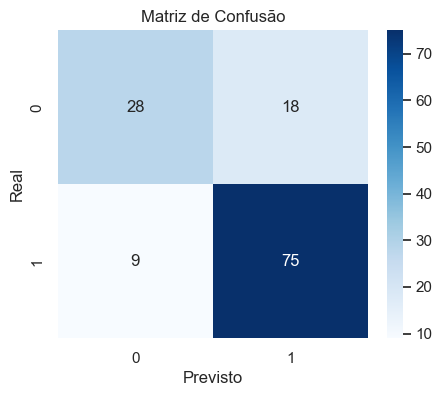

In [21]:
# Estratificação para garantir proporção de classes em cada fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation para avaliar o modelo de forma robusta
cv_scores = cross_val_score(best_model, X, y, cv=skf, scoring='accuracy', n_jobs=-1)
print("Acurácia média CV:", cv_scores.mean())

# Predição nos dados de validação
y_val_pred = best_model.predict(X_val)

# Métricas principais
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall:", recall_score(y_val, y_val_pred))
print("F1-score:", f1_score(y_val, y_val_pred))

# Relatório detalhado por classe
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Matriz de confusão para visualização de erros e acertos
conf_mat = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(5,4))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()


# Predição e submissão

In [22]:
test_pred = best_model.predict(test)

submission = sample_submission.copy()
submission['labels'] = test_pred
submission.to_csv('submission2.csv', index=False)
print("Arquivo submission.csv criado!")


Arquivo submission.csv criado!
